In [68]:
import pandas as pd
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

# data_file = 'packet_data.csv'
data_file = 'resampled_data.csv'


def read_data():
    try:
        df = pd.read_csv(data_file, parse_dates=['Timestamp'])
        logging.info(f"Data read: {df.shape} rows")
        return df
    except Exception as e:
        logging.error(f"Error reading data: {e}")
        return pd.DataFrame()


if __name__ == '__main__':
    data = read_data()
    print(data.head())


2024-06-04 21:02:21,218 INFO Data read: (51, 5) rows


            Timestamp                                           SourceIP  \
0 2024-06-04 20:21:50  34.120.52.64130.231.7.19270.34.201.152130.231....   
1 2024-06-04 20:22:00  130.231.7.19252.112.238.88130.231.7.19252.112....   
2 2024-06-04 20:22:10  130.231.7.19252.85.243.87130.231.7.192130.231....   
3 2024-06-04 20:22:20  52.108.56.17130.231.7.192130.231.7.19252.98.14...   
4 2024-06-04 20:22:30  130.231.7.19252.98.149.178130.231.7.192130.231...   

                                       DestinationIP  \
0  130.231.7.19234.120.52.64130.231.7.19270.34.20...   
1  52.112.238.88130.231.7.19252.112.238.127130.23...   
2  52.85.243.87130.231.7.19252.85.243.8752.85.243...   
3  130.231.7.19252.98.149.17852.98.149.178130.231...   
4  35.176.23.94130.231.7.19252.98.149.17852.98.14...   

                                            Protocol  Length  
0  TLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLST...    1558  
1      TLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLSTLS    1434  
2  TLSTLSTLSTLSTL

In [60]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, save_model
from keras.layers import Conv1D, MaxPooling1D, Flatten, RepeatVector, LSTM, Dense

import logging
from data_handler import read_data

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

model_file = 'trained_model.h5'
scaler_file = 'scaler.gz'
sequence_length = 60


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data['Length'].iloc[i:i + seq_length].astype(float)
        y = data['Length'].iloc[i + seq_length].astype(float)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


def create_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(sequence_length, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        RepeatVector(1),
        LSTM(25, activation='relu', return_sequences=True),
        LSTM(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def train_and_save_model():
    logging.info("Training model...")
    df = read_data()
    if df.empty:
        logging.error("No data available for training")
        return

    df_resampled = df.resample('10s', on='Timestamp').sum().fillna(0).reset_index()

    scaler = MinMaxScaler()
    df_resampled['Length'] = scaler.fit_transform(df_resampled[['Length']])
    X, y = create_sequences(df_resampled, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = create_model()
    model.fit(X, y, epochs=10, verbose=1, validation_split=0.2)

    save_model(model, model_file)
    joblib.dump(scaler, scaler_file)
    logging.info("Model trained and saved.")


if __name__ == '__main__':
    print("Training model...")
    train_and_save_model()

2024-06-04 20:34:20,016 INFO Training model...
2024-06-04 20:34:20,023 INFO Data read: (1790, 5) rows


Training model...


IndexError: tuple index out of range

In [61]:
import numpy as np
from keras.models import load_model
import joblib
from model_trainer import train_and_save_model, create_sequences, sequence_length
from data_handler import read_data
model = load_model(model_file)
scaler = joblib.load(scaler_file)
print("Model and scaler loaded successfully.")

Model and scaler loaded successfully.


In [62]:
df = read_data()
df.head()

2024-06-04 20:34:28,655 INFO Data read: (1790, 5) rows


Timestamp       SourceIP   DestinationIP Protocol  Length
0 2024-06-04 20:21:53.275275   34.120.52.64   130.231.7.192      TLS      81
1 2024-06-04 20:21:53.275771  130.231.7.192    34.120.52.64      TLS      85
2 2024-06-04 20:21:53.539071  70.34.201.152   130.231.7.192      TLS      85
3 2024-06-04 20:21:53.539392  130.231.7.192   70.34.201.152      TLS      89
4 2024-06-04 20:21:53.610402  130.231.7.192  52.112.238.127      TLS     112

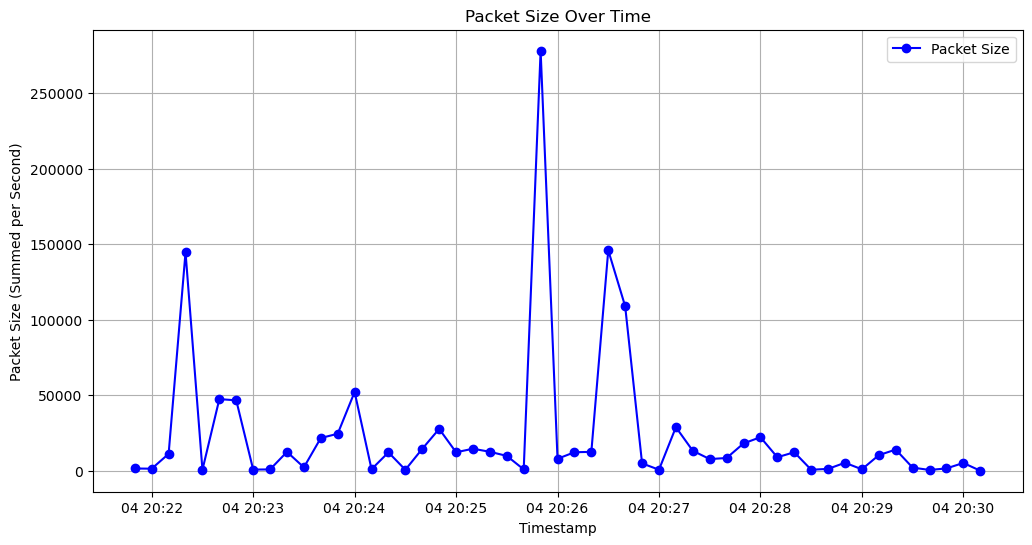

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the data
df = pd.read_csv('packet_data.csv', parse_dates=['Timestamp'])

# Step 2: Set the 'Timestamp' column as the index
df.set_index('Timestamp', inplace=True)

# Step 3: Resample the data to 1-second intervals and sum the packet sizes
df_resampled = df.resample('10s').sum().fillna(0).reset_index()

# Step 4: Plot the data as a line chart
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Timestamp'], df_resampled['Length'], label='Packet Size', color='blue', linestyle='-', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Packet Size (Summed per Second)')
plt.title('Packet Size Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Step 4: Create sequences for testing
X, y = create_sequences(df_resampled, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))
df_resampled = df.resample('10s', on='Timestamp').sum().fillna(0).reset_index()
df_resampled['Length'] = scaler.transform(df_resampled[['Length']])

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [65]:
# Step 5: Make a prediction
if len(X) > 0:
    sample_input = X[0].reshape((1, sequence_length, 1))
    predicted_value = model.predict(sample_input)
    print(f"Predicted value: {predicted_value[0][0]}")
else:
    print("No valid sequences available for prediction.")

1/1 [==============================] - 1s 538ms/step
Predicted value: -171.7186737060547


Original Data:
                   Timestamp       SourceIP   DestinationIP Protocol  Length
0 2024-06-04 20:21:53.275275   34.120.52.64   130.231.7.192      TLS      81
1 2024-06-04 20:21:53.275771  130.231.7.192    34.120.52.64      TLS      85
2 2024-06-04 20:21:53.539071  70.34.201.152   130.231.7.192      TLS      85
3 2024-06-04 20:21:53.539392  130.231.7.192   70.34.201.152      TLS      89
4 2024-06-04 20:21:53.610402  130.231.7.192  52.112.238.127      TLS     112
Resampled Data:
                                                              SourceIP  \
Timestamp                                                                
2024-06-04 20:21:50  34.120.52.64130.231.7.19270.34.201.152130.231....   
2024-06-04 20:22:00  130.231.7.19252.112.238.88130.231.7.19252.112....   
2024-06-04 20:22:10  130.231.7.19252.85.243.87130.231.7.192130.231....   
2024-06-04 20:22:20  52.108.56.17130.231.7.192130.231.7.19252.98.14...   
2024-06-04 20:22:30  130.231.7.19252.98.149.178130.231.7.192130

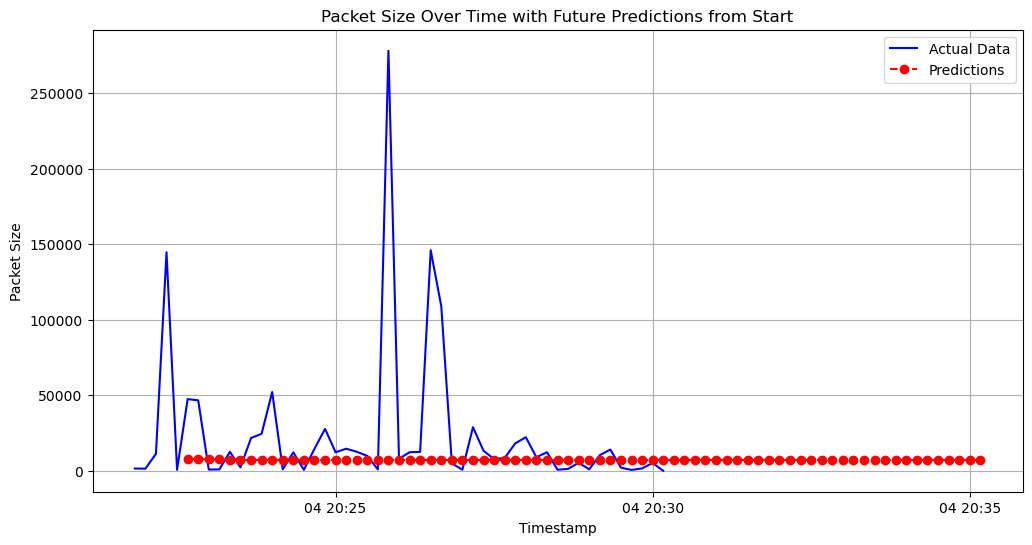

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import load_model

# Step 1: Read the data
df = pd.read_csv('packet_data.csv', parse_dates=['Timestamp'])
print("Original Data:")
print(df.head())

# Step 2: Set the 'Timestamp' column as the index
df.set_index('Timestamp', inplace=True)

# Step 3: Resample the data to 10-second intervals and sum the packet sizes
df_resampled = df.resample('10s').sum().fillna(0)
print("Resampled Data:")
print(df_resampled.head())

# Step 4: Scale the data
scaler = MinMaxScaler()
df_resampled['Length'] = scaler.fit_transform(df_resampled[['Length']])
print("Scaled Data:")
print(df_resampled.head())

# Step 5: Create sequences for testing
sequence_length = 5  # Adjusted sequence length to match the trained model

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].tolist())
        y.append(data.iloc[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df_resampled['Length'], sequence_length)
print("Generated Sequences:")
print(X.shape, y.shape)
print("First Sequence (X[0]):", X[0])
print("Corresponding Target (y[0]):", y[0])

X = X.reshape((X.shape[0], X.shape[1], 1))
print("Reshaped Sequences for Model Input:")
print(X.shape)

# Load your trained model
model = load_model('trained_model.h5')

# Step 6: Make predictions from the start of the time series and for an additional 5 minutes
num_predictions = 30  # 30 predictions for 5 minutes ahead at 10s intervals
predictions = []

# Start with the initial sequences from the dataset
initial_sequence = X[0]  # Start with the first sequence in the dataset

# Generate predictions for the length of the dataset and additional 5 minutes
for i in range(len(df_resampled) - sequence_length + num_predictions):
    pred = model.predict(initial_sequence.reshape((1, sequence_length, 1)))[0, 0]
    predictions.append(pred)
    
    new_sequence = np.append(initial_sequence[1:], [[pred]], axis=0)
    initial_sequence = new_sequence

print("Predictions (Scaled):")
print(predictions[:10])

# Inverse scale the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
print("Predictions (Original Scale):")
print(predictions[:10])

# Inverse scale the actual data
df_resampled['Length'] = scaler.inverse_transform(df_resampled[['Length']])
print("Inverse Scaled Data:")
print(df_resampled.head())

# Create future timestamps
future_timestamps = [df_resampled.index[sequence_length - 1] + pd.Timedelta(seconds=10 * i) for i in range(1, len(predictions) + 1)]

# Plot the data and predictions
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['Length'], label='Actual Data', color='blue')
plt.plot(future_timestamps, predictions, label='Predictions', color='red', linestyle='--', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Packet Size')
plt.title('Packet Size Over Time with Future Predictions from Start')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
#TESTING